In [65]:
# install converter package
# see https://onnx.ai/sklearn-onnx/introduction.html

#!pip install --user skl2onnx

# after installation, need to restart the session and make sure to tick 'use python packages installed in CERNBox'

In [66]:
# general imports

from functools import partial
import numpy as np
rng = np.random.default_rng()
import matplotlib.pyplot as plt
from sklearn.decomposition import MiniBatchNMF
from sklearn.preprocessing import normalize

from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

Shape of X_train: (20, 50)


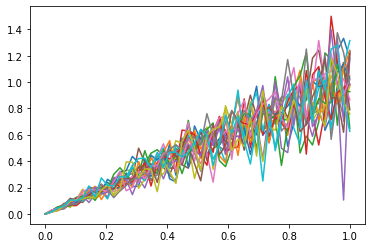

In [67]:
# make some toy data

data_shape = 50
n_instances = 20
xax = np.linspace(0, 1, num=data_shape)
y = xax
noise = rng.normal(scale=0.2*y, size=(n_instances, data_shape))
X_train = y + noise
print(f'Shape of X_train: {X_train.shape}')

# make a plot
fig, ax = plt.subplots()
for i in range(n_instances): ax.plot(xax, X_train[i, :])

/eos/user/l/llambrec/.local/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:2288: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


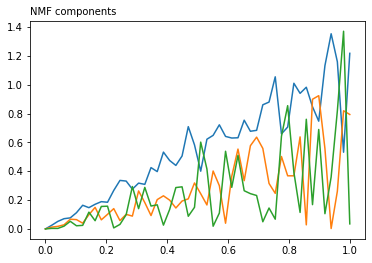

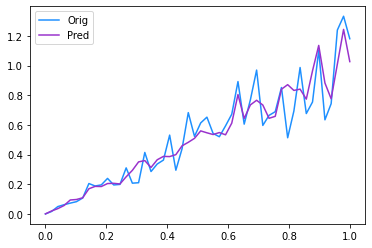

In [68]:
# make an NMF model

# make NMF
nmf = MiniBatchNMF(
  n_components = 3,
  batch_size = 5
)

# fit to data
_ = nmf.fit(X_train)
#nmf.components_ = normalize(nmf.components_, axis=1)
# (note: the normalization step above appears to improve things if no approximation steps are used,
#        but seems to be not needed with sufficient approximation steps.)

# plot components
fig, ax = plt.subplots()
for i in range(nmf.n_components_): ax.plot(xax, nmf.components_[i, :])
ax.text(0, 1.02, 'NMF components', ha='left', va='bottom', transform=ax.transAxes)

# get transformed and reverse-transformed data for comparison later
X_trans = nmf.transform(X_train)
X_pred = nmf.inverse_transform(nmf.transform(X_train))

# plot an example
fig, ax = plt.subplots()
idx = 0
ax.plot(xax, X_train[idx, :], color='dodgerblue', label='Orig')
ax.plot(xax, X_pred[idx, :], color='darkorchid', label='Pred')
ax.legend()

In [69]:
# need to define and register custom converters
# see https://onnx.ai/sklearn-onnx/auto_tutorial/plot_icustom_converter.html
# and chatGPT...

from sklearn.base import BaseEstimator, TransformerMixin
from skl2onnx import update_registered_converter
from skl2onnx.algebra.onnx_ops import OnnxMatMul, OnnxRelu, OnnxAdd, OnnxDiv, OnnxMul
from onnx import onnx_pb as onnx_proto

class NMFTransformWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, model):
        self.model = model
        
    def fit(self, X, y=None):
        # dummy since model is supposed to be already trained
        return self
    
    def transform(self, X):
        return self.model.inverse_transform(self.model.transform(X))

def nmf_transform_shape_calculator(operator):
    input_type = operator.inputs[0].type
    n_features = input_type.shape[1]
    n_components = operator.raw_operator.model.n_components
    operator.outputs[0].type = FloatTensorType([None, n_features])

def nmf_transform_converter(scope, operator, container):
    
    # set number of approximation steps (hard-coded for now)
    n_approx_steps = 50
    
    # get raw model
    model = operator.raw_operator.model
    
    # get input and output names
    input_name = operator.inputs[0]
    output_name = operator.outputs[0].full_name
    
    # get the model components (H) and their transpose
    # H is of shape (n_components, n_features)
    # H_T is of shape (n_features, n_components)
    H = model.components_.astype(np.float32)
    H_T = H.T
    H_name = scope.get_unique_variable_name("H")
    H_T_name = scope.get_unique_variable_name("H_T")
    container.add_initializer(H_name,
                              onnx_proto.TensorProto.FLOAT,
                              H.shape,
                              H.flatten())
    container.add_initializer(H_T_name,
                              onnx_proto.TensorProto.FLOAT,
                              H_T.shape,
                              H_T.flatten())
    
    # also get H times H_T, the epsilon parameter, and X times H_T,
    # needed for the approximation of sklearns internal least squares solver
    if n_approx_steps > 0:
        HH_T = np.matmul(H, H_T)
        eps = np.array([1e-8], dtype=np.float32)
        HH_T_name = scope.get_unique_variable_name("HH_T")
        eps_name = scope.get_unique_variable_name("eps")
        container.add_initializer(HH_T_name, onnx_proto.TensorProto.FLOAT, HH_T.shape, HH_T.flatten())
        container.add_initializer(eps_name, onnx_proto.TensorProto.FLOAT, [1], eps)
        XH_T_name = scope.get_unique_variable_name("XH_T")
        XH_T = OnnxMatMul(input_name, H_T_name, output_names=[XH_T_name], op_version=container.target_opset)
        XH_T.add_to(scope, container)

    # Step 1: W_pre = ReLU(X @ H^T)
    # matrix dimensons: (n_instances, n_features)
    #                   * (n_features, n_components)
    #                   = (n_instances, n_components)
    W0_raw = scope.get_unique_variable_name("W0_raw")
    W0 = scope.get_unique_variable_name("W0")

    matmul1 = OnnxMatMul(operator.inputs[0], H_T_name,
                         output_names=[W0_raw],
                         op_version=container.target_opset)

    relu = OnnxRelu(matmul1,
                    output_names=[W0],
                    op_version=container.target_opset)
    W_current = W0
    
    # Step 1b: improve the approximation (optional)
    for stepidx in range(n_approx_steps):
        denom = scope.get_unique_variable_name(f"denom_{stepidx}")
        denom_eps = scope.get_unique_variable_name(f"denom_eps_{stepidx}")
        frac = scope.get_unique_variable_name(f"frac_{stepidx}")
        W_next = scope.get_unique_variable_name(f"W_{stepidx}")
        
        matmul_denom = OnnxMatMul(W_current, HH_T_name, output_names=[denom], op_version=container.target_opset)
        add_eps = OnnxAdd(denom, eps_name, output_names=[denom_eps], op_version=container.target_opset)
        div = OnnxDiv(XH_T_name, denom_eps, output_names=[frac], op_version=container.target_opset)
        update = OnnxMul(W_current, frac, output_names=[W_next], op_version=container.target_opset)
        
        W_current = W_next
        
        for node in [matmul_denom, add_eps, div, update]:
            node.add_to(scope, container)

    # Step 2: X̂ = W @ H
    # matrix dimensions: (n_instances, n_components)
    #                    * (n_components, n_features)
    #                    = (n_instances, n_features)
    recon_out = operator.outputs[0].full_name

    matmul2 = OnnxMatMul(W_current, H_name,
                         output_names=[recon_out],
                         op_version=container.target_opset)

    # Add nodes to container
    for node in [matmul1, relu, matmul2]:
        node.add_to(scope, container)

# Register the converter for our wrapper
converter = nmf_transform_converter
update_registered_converter(
    NMFTransformWrapper, "NMFTransformWrapper",
    nmf_transform_shape_calculator, converter)

In [70]:
# convert model to ONNX

initial_type = [
    ('input', FloatTensorType([None, X_train.shape[1]])),
]
nmf_wrapped = NMFTransformWrapper(nmf)
nmf_onnx = convert_sklearn(nmf_wrapped, initial_types=initial_type)
with open('test.onnx', "wb") as f:
    f.write(nmf_onnx.SerializeToString())

In [71]:
# read ONNX model and run inference

import onnxruntime as rt

session = rt.InferenceSession("test.onnx", providers=["CPUExecutionProvider"])
input_name = session.get_inputs()[0].name
label_name = session.get_outputs()[0].name
pred_onnx = session.run([label_name], {input_name: X_train.astype(np.float32)})[0]

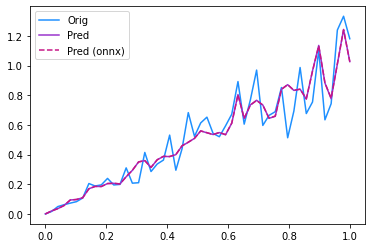

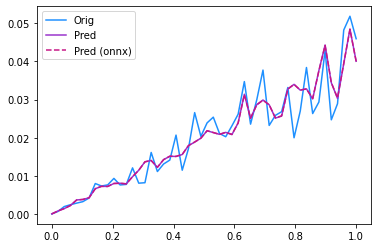

In [72]:
# compare direct transform with detour via ONNX

idx = 0
fig, ax = plt.subplots()
ax.plot(xax, X_train[idx, :], color='dodgerblue', label='Orig')
ax.plot(xax, X_pred[idx, :], color='darkorchid', label='Pred')
ax.plot(xax, pred_onnx[idx, :], color='mediumvioletred', linestyle='--', label='Pred (onnx)')
ax.legend()

# same but normalized
fig, ax = plt.subplots()
ax.plot(xax, X_train[idx, :]/np.sum(X_train[idx, :]), color='dodgerblue', label='Orig')
ax.plot(xax, X_pred[idx, :]/np.sum(X_pred[idx, :]), color='darkorchid', label='Pred')
ax.plot(xax, pred_onnx[idx, :]/np.sum(pred_onnx[idx, :]), color='mediumvioletred', linestyle='--', label='Pred (onnx)')
ax.legend()